# Building A Better Dish Finder

## The goal of the project is to build an app that allows a user to find local resturants and eateries that specialize in a specific dish. This could be anything - bagels, pizza, chicken wings, tacos. We are looking to redefine what it means for a resturant to be "good", as many resturants specialize in certain dishes.

## The dataset can be found at https://www.yelp.com/dataset.

In [83]:
import numpy as np
import time
import scipy
import pandas as pd
import dask.bag as db
import json
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
import mplleaflet
import folium
import geopandas
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from scipy.special import factorial as factorial
%matplotlib notebook
pd.set_option('display.max_columns', None)

## Here we will focus on a specific data set, the Toronto data, and work to increase the speed of the bayseian inferance

In [84]:
Toronto = pd.read_csv('toronto.csv')

In [85]:
Toronto.head()

,Unnamed: 0,address,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,stars_x,state,cool,date,funny,stars_y,text,user_id,simid,usid
0,27,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,0,2012-09-11 04:15:13,0,5,"i love this service, a client had referred me ...",Dl6Y6sjVGL7br1O44rXDQg,123,18425
1,28,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,0,2013-10-31 16:08:34,0,5,i have been with fdo for a year now and i love...,AHXy4uTg_L8VFXNRufLYdQ,123,14150
2,29,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,2,2010-09-11 11:50:58,0,4,"you know, i think i was in a super-good mood w...",TaJ3hRYUW9Z82HF0qc4hFQ,123,38217
3,30,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,0,2015-05-20 22:43:50,0,5,"this company is flexible, caring, and committe...",9sDNyyANgUMNg0RsuR0E7A,123,13677
4,31,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,0,2010-08-09 23:51:42,0,5,they can 'splain it better than me. from thei...,TaJ3hRYUW9Z82HF0qc4hFQ,123,38217


### We can use a bayesian  model in order to sample from the posterior distribution. Here, we use the total resturant reviews in order to inform the prior distribution of the quality of the individual dish. This should make intutive sense - the better the resturant is, the more likely it will be that a specific dish is good. The worse a resturant is, the less likely. By using the total resturant information as the prior, we are biasing our results towards the general quality of the resturant. But if a specific dish is really good (or really bad), this will show up when we calculate the likelihood


# $P(\lambda_{taco} \vert $reviews$) \propto P($reviews of tacos$ \vert \lambda_{taco}) * P(\lambda_{all} \vert $reviews$)$

### Where the likelihood is defined as

# $P($reviews $\vert \lambda)$ = $\prod P(k_{stars}, \lambda)$ = $\prod \lambda^k e^{-\lambda}/Zk! $

### with k the number of stars awarded (from 0 to 4) and Z the normalization so the probability sums to 1

In [3]:
def Z(lam):
    return np.exp(-lam)*(1 + lam + lam**2/2 + lam**3/6 + lam**4/(6*4))

def poisson_prob(lam):
    vec = []
    for k in range(5):
        vec.append(lam**k * np.exp(-lam)/(Z(lam)*np.math.factorial(k)))
    return vec

def likelihood(lam,k):
    logprob = (k*np.log(lam) - lam - np.log(Z(lam)) - np.log(factorial(k))).sum()
    return logprob

### We can test this one just a single business to start

In [8]:
businesses = Toronto[Toronto['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)]['business_id'].value_counts().index.to_list()

sb = Toronto[Toronto['business_id'] == businesses[10]]
allstars = sb.stars_y.to_list() 
fooditem_stars = sb[sb['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)].stars_y.to_list()
    
    
with pm.Model() as test_model:

    lam_resturant = pm.Uniform('lam_rest',0,10)
    y_obs_2 = pm.Potential('y_obs_2',likelihood(lam_resturant,np.array(allstars)-1))
    
    lam_taco = pm.Normal('lam_tacos',mu=lam_resturant,sd=np.sqrt(lam_resturant))
    y_obs = pm.Potential('y_obs',likelihood(lam_taco,np.array(fooditem_stars)-1))

with test_model:
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step,tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lam_tacos]
>Metropolis: [lam_rest]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6458.15draws/s]
The number of effective samples is smaller than 25% for some parameters.


### And see what the predicted taco score is ($\lambda_{taco}$ in the model). These plots give the probability density of specific parameters, along with the sampling paths for each parameter. This gives us far more information than just a mean and standard deviation, which could be used in further analysis to fine tune our scoring

<IPython.core.display.Javascript object>


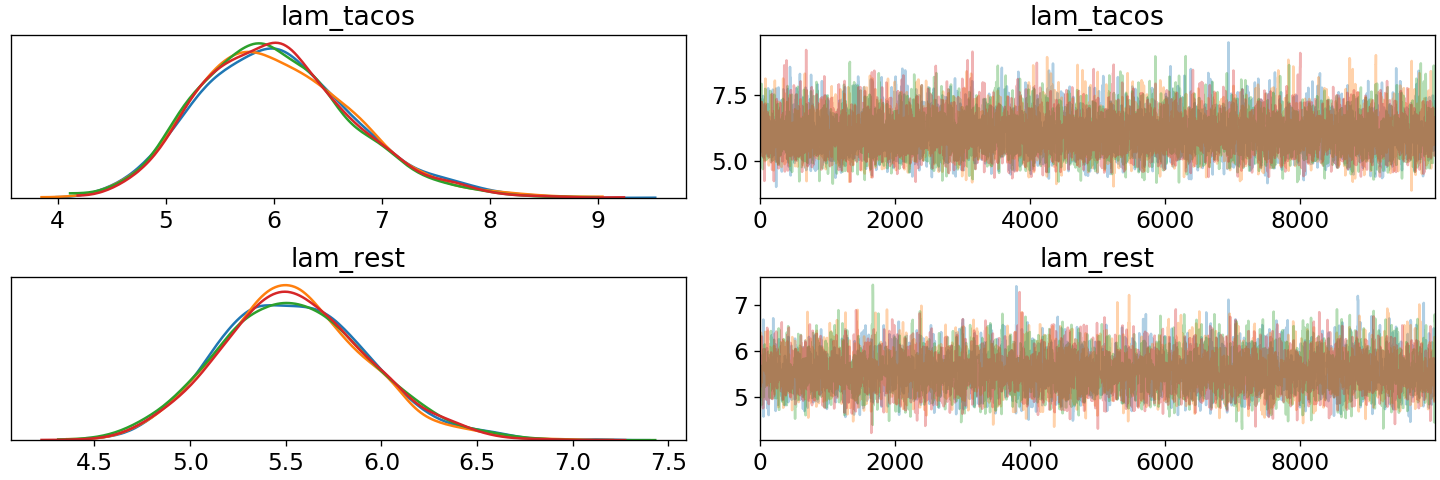

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12733ae80>,
      dtype=object)

In [15]:
pm.traceplot(trace)

In [19]:
varnames = ['~mu']
az.summary(trace,varnames,credible_interval=.93).round(3)

,mean,sd,hpd_3.5%,hpd_96.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam_tacos,6.027,0.711,4.747,7.275,0.008,0.005,8680.0,8543.0,8865.0,9161.0,1.0
lam_rest,5.546,0.383,4.837,6.220,0.004,0.003,7548.0,7491.0,7628.0,7410.0,1.0


### A key question would be to see if this actually does any better at predicting how highly people will rate tacos. We can compare it to just the base model. Here, we actually see that the resturant in question scores higher for its tacos than it does overall! Those must be good tacos

### Another question is, would we just be better off using the taco only data?

In [20]:
sb = Toronto[Toronto['business_id'] == businesses[10]]
allstars = sb.stars_y.to_list() 
fooditem_stars = sb[sb['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)].stars_y.to_list()
    
    
with pm.Model() as test_model:

    lam_taco = pm.Uniform('lam_taco',0,10)
    y_obs = pm.Potential('y_obs',likelihood(lam_taco,np.array(fooditem_stars)-1))

with test_model:
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step,tune=5000)

Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:07<00:00, 8358.10draws/s]


<IPython.core.display.Javascript object>


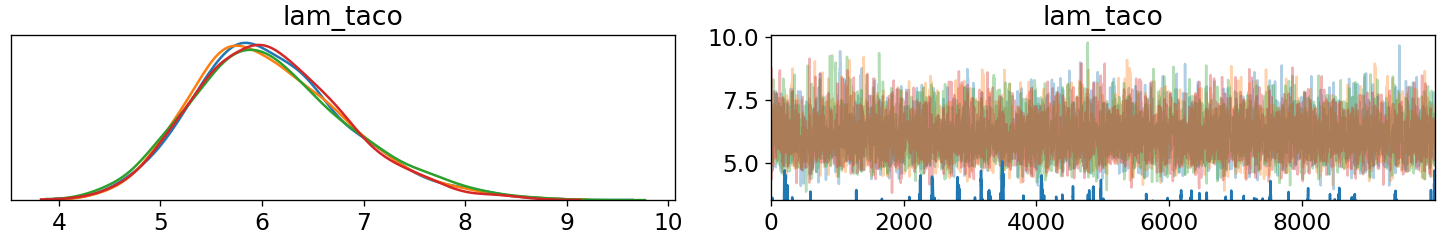

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129b05c18>,
      dtype=object)

In [21]:
pm.traceplot(trace)

In [22]:
az.summary(trace,varnames,credible_interval=.93).round(3)

,mean,sd,hpd_3.5%,hpd_96.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam_taco,6.1,0.767,4.746,7.494,0.009,0.007,7198.0,6877.0,7627.0,7002.0,1.0


# Addition (7/9/20): Although using pymc3 to get the taco score is highly robust, it is admittedly (very) slow. We can increase the speed by noting that the distributions we are using are not very complicated, and can build our own metropolis sampler

## The first step is to find a reasonable starting point for our sampling. Given a list of star reviews, we can compute the most probable value of $\lambda$ for our distribution by taking a derivative of the likelihood with respect to $\lambda$. Then, we can use a metropolis sampler with uniform prior (from 0 to maxlambda) in order get a rough sample of the distribution


--- 0.22397804260253906 seconds ---


Text(0, 0.5, 'Probability Density')

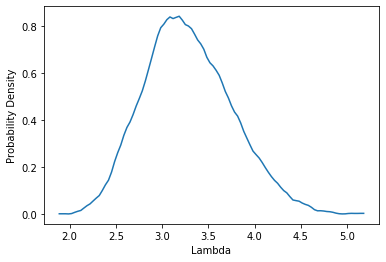

In [4]:
def func(lam,stars):
    N = len(stars)
    sumval = sum(stars)
    return -N + sumval/lam + lam**4/(24*(1+lam+lam**2/2+lam**3/6+lam**4/24))

def logp(lam,stars):
    N = len(stars)
    return -N*lam + sum(stars)*np.log(lam) - np.log(Z(lam))

def step(lam,stars,maxlam,delta):
    newlam = lam + delta*np.random.uniform(-1,1)
    if (newlam > maxlam) or (newlam < 0):
        return lam
    oldp = logp(lam,stars)
    newp = logp(newlam,stars)
    if np.random.uniform(0,1) < np.exp(newp - oldp):
        return newlam
    else:
        return lam
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    
def return_lam_samples(stars,maxlam):
    delta = .5 #reasonable value to take, considering spread is rather small
    numsamps = 10000 #Good sampling value
    try:
        results = scipy.optimize.root_scalar(func,args=stars,bracket=[.1,100],method='brentq')
        start = results.root
    except:
        print('setting start lambda to max value')
        start = maxlam
        
        
    lam = [start]
    for i in range(numsamps):
        lam.append(step(lam[-1],stars,maxlam,delta))
    return lam

def step_with_prior(lam,stars,maxlam,delta,prior):
    prior_index = prior[0]
    prior_prob = prior[1]
    
    newlam = lam + delta*np.random.uniform(-1,1)
    if (newlam > maxlam) or (newlam < 0):
        return lam
   
    oldp = logp(lam,stars) +  np.log(prior_prob[find_nearest(prior_index,lam)])
    newp = logp(newlam,stars) +  np.log(prior_prob[find_nearest(prior_index,newlam)])
    if np.random.uniform(0,1) < np.exp(newp - oldp):
        return newlam
    else:
        return lam
    
def return_lam_samples_with_prior(stars,maxlam,prior):
    delta = .5 #reasonable value to take, considering spread is rather small
    numsamps = 20000 #Good sampling value, we want to take more since this will be the final output
    
    lam = [3]
    for i in range(numsamps):
        lam.append(step_with_prior(lam[-1],stars,maxlam,delta,prior))
    return lam[100:]

def pdf_from_stars(stars,maxlam):
    lams = return_lam_samples(stars,maxlam)
    sortedVals = np.sort(lams)
    lamvals = np.linspace(min(sortedVals),max(sortedVals),100)
    count = 0

    CDF = np.zeros(100)


    for i in range(len(lamvals)):
        while sortedVals[count] < lamvals[i]:
            count += 1
        CDF[i] = count

    CDF = CDF/len(sortedVals)
    CDF = scipy.signal.savgol_filter(CDF,5,1)
    pdf = np.gradient(CDF,lamvals)
    return lamvals,pdf

start_time = time.time()
    
allstars_test = [1,4,4,4,2,2,3,2,2,4,4,4,4,4,3]
results = pdf_from_stars(allstars_test,10)
print("--- %s seconds ---" % (time.time() - start_time))
plt.figure()
plt.plot(results[0],results[1])
plt.xlabel('Lambda')
plt.ylabel('Probability Density')

## As we can see, this very quickly gets a good estimate of the prior for $\lambda_{taco}$. The next step would be to get a sampling of the taco stars likelihood, given this prior. This is easy since we already have the prior distribution for the resturant stars. 

## $P(\lambda_{tacos}) = \sum_{\lambda} P(\lambda_{tacos} \vert \lambda) * P(\lambda)$
## We can model the conditional probability as a gaussian with std ~1 (indicating uncertainty in the relation between a good resturant and good tacos)

--- 0.03367781639099121 seconds ---


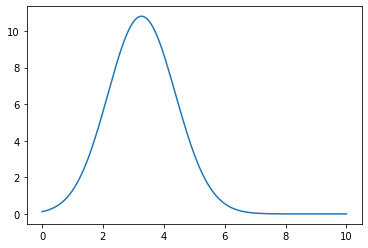

In [5]:
def specific_pdf(pdf,maxlam):
    pdf_index = pdf[0]
    pdf_values = pdf[1]
    specific_pdf_index = np.linspace(0,maxlam,1000)
    specific_pdf_values = np.zeros(1000)
    count = 0
    for value in specific_pdf_index:
        specific_pdf_values[count] = sum(1/np.sqrt(2*np.pi) * np.exp(-(value-pdf_index)**2/(2)) * pdf_values)
        count += 1
    return specific_pdf_index,specific_pdf_values

start_time = time.time()
newresults = specific_pdf(results,10)
print("--- %s seconds ---" % (time.time() - start_time))

plt.figure()
plt.plot(specific_pdf(results,10)[0],specific_pdf(results,10)[1])

## This piece is also extremely fast!

## Next we will put it all togeather in a single function in order to sample the full distribution

--- 0.8431699275970459 seconds ---


(array([0.00760148, 0.00380074, 0.00380074, 0.00380074, 0.01235241,
        0.02660518, 0.01710333, 0.0190037 , 0.03230629, 0.04370851,
        0.06841332, 0.06271221, 0.08076573, 0.09881925, 0.09121777,
        0.13492628, 0.15583035, 0.15107943, 0.2099909 , 0.21759238,
        0.2289946 , 0.26890237, 0.31926218, 0.30595959, 0.33541533,
        0.36867181, 0.37722347, 0.40287847, 0.42853346, 0.50834901,
        0.4959966 , 0.4959966 , 0.50549845, 0.4959966 , 0.51214975,
        0.50454827, 0.51214975, 0.58341363, 0.51119957, 0.4836442 ,
        0.51309994, 0.49124568, 0.45418846, 0.4959966 , 0.47604272,
        0.43518476, 0.41808143, 0.41523087, 0.4009781 , 0.3753231 ,
        0.36677144, 0.34206662, 0.35061829, 0.30500941, 0.27840422,
        0.26985256, 0.25274923, 0.20809053, 0.21379164, 0.19193738,
        0.17388387, 0.15963109, 0.1396772 , 0.11687276, 0.12637461,
        0.08361629, 0.07411444, 0.08076573, 0.06081184, 0.06461258,
        0.07126388, 0.05321036, 0.04655907, 0.03

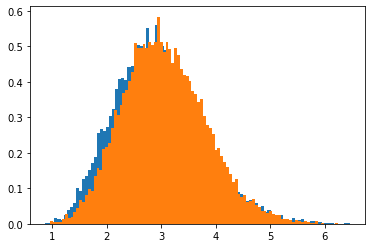

In [6]:
def full_lambda_samples(allstars,specificstars,maxlam):
    pdf = pdf_from_stars(allstars,maxlam)
    specific_prior_pdf = specific_pdf(pdf,maxlam)
    
    return return_lam_samples_with_prior(specificstars,maxlam,specific_prior_pdf)


    
    
start_time = time.time()
newresults = full_lambda_samples([1,1,2,3,3,3,4],[2,3,3],10)
print("--- %s seconds ---" % (time.time() - start_time))

plt.figure()
plt.hist(full_lambda_samples([1,1,2,3,3,3,4],[2,3,3],10),bins=100,density=True)
plt.hist(full_lambda_samples([1,1,2,3,3,3,4],[2,3,4],10),bins=100,density=True)


## This takes quite a bit longer, but still is reasonable - 2 seconds per sample. Additionally, we can see that shifting one of the stars from the subset of all reviews can have a significant role in changing our final distribution

# Now that we have our final function, we can quickly compare different businesses. We are also going to have to narrow our search, since the search time is going to become unreasonably long. How long would a user really wait for some search results? Maybe 30 seconds, a minute? We are going to have to pick out the top 15 most likely candidates until we have a faster algorithm in real time, but this allows us to quickly query the database in a reasonable amount of time (a couple of minutes) on our end.

## For instance, we can query the top 100 mentions of chocolate croissants to find the best croissants in Toronto

In [13]:
def search(keyword,df):
    businesses = df[df['text'].str.contains(keyword,regex=True)]['business_id'].value_counts().index.to_list()
    try:
        businesses = businesses[:10]
    except:
        businesses = businesses
    
    
    foodscore_dict = {}
    fooddiv_dict = {}
    ratio_dict = {}
    
    samples_dict = {}
    
    for business in businesses:
        sb = df[df['business_id'] == business]
        allstars = sb.stars_y.to_list() 
        fooditem_stars = sb[sb['text'].str.contains(keyword,regex=True)].stars_y.to_list()
        samples = full_lambda_samples(allstars,fooditem_stars,10)
        
        foodscore_dict.update({business : np.mean(samples)/np.sqrt(np.std(samples))})
        ratio_dict.update({business : len(fooditem_stars)/len(allstars)})
        
        name = sb['name'].to_list()[0]
        
        samples_dict.update({name: samples})
        
        
    df['taco'+' score'] = df['business_id'].map(foodscore_dict)
    df['taco'+' ratio'] = df['business_id'].map(ratio_dict)
    
    
    
    newdf = df.groupby('name').mean().sort_values('taco'+' score',ascending=False)
    newdf = newdf[newdf['taco'+ ' score'].notna()]
    
    newdf['Weighted ' + 'taco' + ' score'] = newdf['taco' + ' score']*np.exp(newdf['taco' + ' ratio']/2)
    newdf = newdf.sort_values('Weighted ' + 'taco' + ' score',ascending=False)
    
    
    
    
    namelist = newdf.index.to_list()
    
    samples = []
    for name in namelist:
        samples.append(samples_dict.get(name))
        
    
    
    return newdf,samples

tacos,samples = search('bagel',Toronto)



In [27]:
def fast_search(keyword,df):
    businesses = df[df['text'].str.contains(keyword,regex=True)]['business_id'].value_counts().index.to_list()
    try:
        businesses = businesses[:500]
    except:
        businesses = businesses
    
    
    foodscore_dict = {}
    fooddiv_dict = {}
    ratio_dict = {}
    
    
    for business in businesses:
        sb = df[df['business_id'] == business]
        allstars = sb.stars_y.to_list() 
        fooditem_stars = sb[sb['text'].str.contains(keyword,regex=True)].stars_y.to_list()
        
        totscore = np.mean([np.mean(allstars), np.mean(fooditem_stars)])
        
        
        foodscore_dict.update({business : totscore})
        ratio_dict.update({business : len(fooditem_stars)/len(allstars)})
        
        name = sb['name'].to_list()[0]
        
        

        
    df['taco'+' score'] = df['business_id'].map(foodscore_dict)
    df['taco'+' ratio'] = df['business_id'].map(ratio_dict)
    
    
    
    newdf = df.groupby('name').mean().sort_values('taco'+' score',ascending=False)
    newdf = newdf[newdf['taco'+ ' score'].notna()]
    
    newdf['Weighted ' + 'taco' + ' score'] = newdf['taco' + ' score']*np.exp(newdf['taco' + ' ratio']/2)
    newdf = newdf.sort_values('Weighted ' + 'taco' + ' score',ascending=False)
    
    return newdf

tacos = fast_search('taco',Toronto)



In [24]:
tacos

,Unnamed: 0,is_open,latitude,longitude,stars_x,cool,funny,stars_y,simid,usid,taco score,taco ratio,Weighted taco score
name,,,,,,,,,,,,,
The Annex Commons,3.073717e+06,1.0,43.665449,-79.407899,4.5,0.200000,0.400000,4.400000,1259.000000,27274.800000,4.400000,1.000000,7.254374
Viajero Cantina,8.545880e+05,1.0,43.655279,-79.456340,4.5,0.090909,0.000000,4.727273,3032.000000,45852.363636,4.808081,0.818182,7.238318
El Nahual Tacos,1.835217e+06,1.0,43.666327,-79.406587,4.5,0.886957,0.356522,4.643478,2257.000000,40018.765217,4.641327,0.843478,7.076217
Chilango Taco,2.860202e+06,0.0,43.751243,-79.552002,4.0,2.750000,1.250000,4.250000,5797.000000,36248.500000,4.250000,1.000000,7.007065
Gordy Smiles,2.376304e+06,1.0,43.649211,-79.420922,5.0,0.666667,0.333333,5.000000,902.000000,56147.000000,5.000000,0.666667,6.978062
Itacate,1.614508e+06,1.0,43.679391,-79.437161,4.5,0.514286,0.542857,4.457143,4658.000000,44200.400000,4.445238,0.857143,6.823721
Habitant at Nordstrom,9.316635e+05,1.0,43.725108,-79.452809,4.5,0.750000,1.000000,4.500000,2963.000000,31659.750000,4.583333,0.750000,6.668711
El Trompo Movil,1.942402e+06,1.0,43.654616,-79.388065,4.0,0.000000,0.000000,4.000000,1800.000000,51510.666667,4.000000,1.000000,6.594885
Delight Bite Food Truck,1.542038e+06,1.0,43.671427,-79.384040,4.5,0.000000,0.000000,4.333333,1028.000000,24319.000000,4.416667,0.666667,6.163955


## We can examine what the posterior distribution looks like for the first sample, to get an idea of the entire range of croissant scores we would be likely to see if a consumer went to the resturant

[Text(0, 0.5, 'Probability'),
 (0, 10),
 Text(0.5, 0, 'Score'),
 Text(0.5, 1.0, 'Croissant Score')]

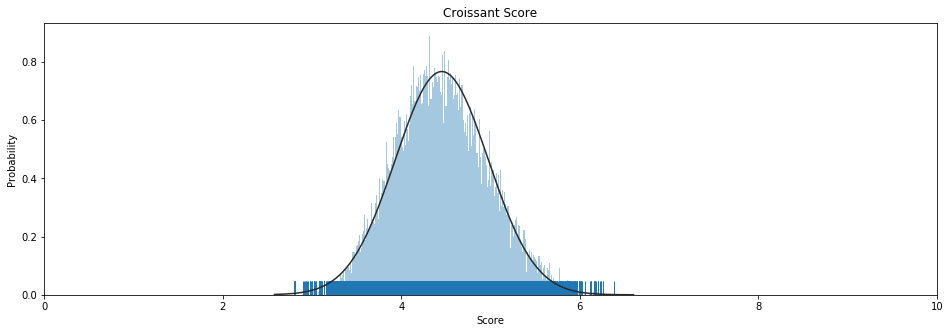

In [16]:
import seaborn as sns
from scipy.stats import norm
plt.figure(figsize=(16,5))
ax = sns.distplot(samples[0],fit=norm,rug=True,bins=300,kde=False)
ax.set(xlabel='Score',ylabel='Probability',title='Croissant Score',xlim=[0,10])

#sns.xlabel('Hello')

## Seeing the entire distribution makes us more confident that, for this resturant (The Danish Pastry House), the user is likely to have a good experiance

[Text(0, 0.5, 'Probability'),
 (0, 10),
 Text(0.5, 0, 'Score'),
 Text(0.5, 1.0, 'Croissant Score')]

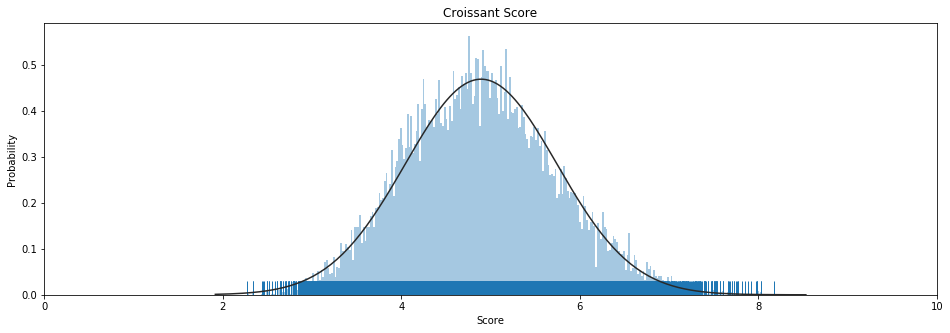

In [18]:
import seaborn as sns
from scipy.stats import norm
plt.figure(figsize=(16,5))
ax = sns.distplot(samples[3],fit=norm,rug=True,bins=300,kde=False)
ax.set(xlabel='Score',ylabel='Probability',title='Croissant Score',xlim=[0,10])

#sns.xlabel('Hello')

## In this case, the Gouter resturant has a much larger range of scores, indicating uncertainty in the result and uncertainty in what a user's experiance will be

# We can use Folium in order to generate really nice interactive maps

In [31]:

def plot_map(df):
    html = """
    Resturant Name: <td>{}</td>
    <br> Food Score: <td>{}</td>
    
    """.format
    
    tacos = df
    tacos['Weighted taco score 2'] = (tacos['Weighted taco score'] - min(tacos['Weighted taco score']))/(max(tacos['Weighted taco score']) - min(tacos['Weighted taco score']))
    toptacos = tacos[:10]
    othertacos = tacos[10:]
    gdf_top = geopandas.GeoDataFrame(toptacos, geometry=geopandas.points_from_xy(toptacos.longitude, toptacos.latitude))
    gdf_top.crs = {'init' :'epsg:4326'}
    
    # Get x and y coordinates for each point
    gdf_top["x"] = gdf_top["geometry"].apply(lambda geom: geom.x)
    gdf_top["y"] = gdf_top["geometry"].apply(lambda geom: geom.y)


    gdf_other = geopandas.GeoDataFrame(othertacos, geometry=geopandas.points_from_xy(othertacos.longitude, othertacos.latitude))
    gdf_other.crs = {'init' :'epsg:4326'}
    
    # Get x and y coordinates for each point
    gdf_other["x"] = gdf_other["geometry"].apply(lambda geom: geom.x)
    gdf_other["y"] = gdf_other["geometry"].apply(lambda geom: geom.y)
    
    #First we deal with the not highly rated resturants

      
    gdf_all = geopandas.GeoDataFrame(tacos, geometry=geopandas.points_from_xy(tacos.longitude, tacos.latitude))
    gdf_all.crs = {'init' :'epsg:4326'}
    
    # Get x and y coordinates for each point
    gdf_all["x"] = gdf_all["geometry"].apply(lambda geom: geom.x)
    gdf_all["y"] = gdf_all["geometry"].apply(lambda geom: geom.y)
    
    # Create a list of coordinate pairs
    locations_with_weights = list(zip(gdf_all["y"], gdf_all["x"],np.exp(5*(gdf_other['Weighted taco score 2']-.3))))
    
    locations = list(zip(gdf_other["y"], gdf_other["x"]))

   
    m = folium.Map(location=[43.65,-79.38], tiles = 'cartodbpositron', zoom_start=11, control_scale=True)

    width, height = 300,50
    popups, locations,icons = [], [],[]

    for idx, row in gdf_other.iterrows():
        locations.append([row['geometry'].y, row['geometry'].x])
        name = idx
    
        iframe = folium.IFrame(html(name,row['Weighted taco score 2']), width=width, height=height)
        popups.append(folium.Popup(iframe))
        icons.append(folium.Icon(icon='info',prefix='fa'))
    
    h = folium.FeatureGroup(name='Resturant')

    h.add_child(MarkerCluster(locations=locations,icons=icons, popups=popups))
    m.add_child(h)


    points_gjson = folium.features.GeoJson(gdf_other, name="Tacos")
    HeatMap(locations_with_weights,min_opacity=.3).add_to(m)
    
    
    #Now we deal with the highly rated resturants
    locations = list(zip(gdf_top["y"], gdf_top["x"]))
    
    popups, locations,icons = [], [],[]

    for idx, row in gdf_top.iterrows():
        locations.append([row['geometry'].y, row['geometry'].x])
        name = idx
    
        iframe = folium.IFrame(html(name,row['Weighted taco score 2']), width=width, height=height)
        popups.append(folium.Popup(iframe))
        icons.append(folium.Icon(color='lightred',icon='thumbs-up',prefix='fa'))
    
    h2 = folium.FeatureGroup(name='Top Resturant')
    for i in range(len(icons)):
        h2.add_child(folium.Marker(location=locations[i],icon=icons[i],popup=popups[i]))

    m.add_child(h2)
    display(m)
    m.save('taco_map.html')

    
plot_map(tacos)

/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://

# It also might be nice to try a way to cluster the resturants togeather based on reviews. This ultimatly did not work, for reasons to be shown later

In [25]:
Simplified = Toronto.sort_values(['business_id'])[['business_id','text','user_id','stars_y']]

In [29]:
businesses = Simplified['business_id'].unique()


In [295]:
def resturant_value(stars1,stars2,avg):
    diffstars = abs(stars2-stars1)
    scale = np.exp((stars1-avg)**2)*np.exp((stars2-avg)**2)
    if diffstars == 0:
        return 2*scale
    elif diffstars == 1:
        return 0*scale
    elif diffstars == 2:
        return -1*scale
    elif diffstars == 3:
        return -2*scale
    elif diffstars == 4:
        return -3*scale

In [296]:
import networkx as nx
import itertools
G = nx.Graph()
for business in businesses:
    reviews = Simplified[Simplified['business_id'] == business]
    userlist,starlist = reviews['user_id'],reviews['stars_y']
    loop = itertools.combinations(range(len(userlist)),2)
    for val in loop:
        weight = resturant_value(starlist.iloc[val[0]],starlist.iloc[val[1]],reviews['stars_y'].mean())
        
        if G.has_edge(userlist.iloc[val[0]],userlist.iloc[val[1]]):
            G[userlist.iloc[val[0]]][userlist.iloc[val[1]]]["weight"] += weight
        else:
            G.add_edge(userlist.iloc[val[0]],userlist.iloc[val[1]],weight=weight)

KeyboardInterrupt: 

In [258]:

def choose_user(dictionary):
    dic = {x:y for x,y in dictionary.items() if y!=0}
    randomvalue = np.random.uniform(0,sum(dic.values()))
    sumval,count = 0,0
    for person,value in zip(dic,dic.values()):
            sumval += value
            if sumval > randomvalue:
                return person
            
def step_forward(user):
    dict_ = {}
    for otheruser in G.adj[user]:
        dict_[otheruser] = transform_weight(G.adj[user][otheruser]['weight'])
    return choose_user(dict_)

def collect_cluster(start,n):
    users = [start]
    dict_ = {}
    for i in range(n):
        users.append(step_forward(users[-1]))

    for name in set(users):
        dict_[name] = users.count(name)
        
    sortedlist = sorted(dict_.items(), key=lambda x: x[1],reverse=True)
    end_cluster = []
    for item in sortedlist:
        if item[1] <=2:
            break
        else:
            end_cluster.append(item)
    return dict(end_cluster)
   


In [442]:



def collect_cluster(start, n,cutoff):
    users = [start]
    cluster = {start: 1}
    pool = 1
    loopnum = 1
    while pool < n and users:
        newusers = []
        for user in users:
            dict_ = {}
            for otheruser in G.adj[user]:
                dict_[otheruser] = G.adj[user][otheruser]['weight']
            sortedlist = sorted(dict_.items(), key=lambda x: x[1],reverse=True)
            maxval = sortedlist[0][1]
            for item in sortedlist:
                
                if item[1] < cutoff:
                    break
                    
                if item[0] not in cluster:
                    newusers.append(item[0])
                    cluster[item[0]]= np.exp(-loopnum)*item[1]/maxval
                    pool +=1
        users = newusers[:]
        loopnum+=1
    return cluster
        
            
    

In [466]:
userlist = list(set(Simplified['user_id']))
clusters = []
for i,user in enumerate(userlist):
    try:
        clusters.append(collect_cluster(user,100,35))
    except KeyError:
        pass
    
    

KeyboardInterrupt: 

In [467]:
trimmedcluster = [cluster for cluster in clusters if len(cluster) > 10]

In [454]:
trimmedcluster[3]

{'VS_dAl_TESGqX7zl4oz7RA': 1,
 'vmM9qIAZ1fEMA_KOjeP1Lg': 0.36787944117144233,
 '5YMGNscC2MVjj-WOf8uz5Q': 0.36787944117144233,
 '3x1x9EoCDo-Niawysv3tJQ': 0.36787944117144233,
 'VkiwkY-Pped3Q9JAatfRdQ': 0.36787944117144233,
 'uPcI86UJmeOO4DUiOgIWlQ': 0.36787944117144233,
 '4Fqzh__Rl06mjQ3B1zhYNA': 0.36787944117144233,
 'Jcv2kyItznY8Q5cW3qJwJA': 0.36787944117144233,
 'QS2DJDJ4P0WVh5mzjMzM8Q': 0.36787944117144233,
 '5R2UdAtfEbpnRa1XK25Hxw': 0.36787944117144233,
 'KtBN8tllBkDcpDOgs6zKMg': 0.36787944117144233,
 'xtnr2uawgvzSZpga69yFyw': 0.36787944117144233,
 'jSrH6gdSHz8C_3LS5if_RQ': 0.36787944117144233,
 '898AQwsw7_EiY_xC2god7w': 0.36787944117144233,
 'RA4F2R4PA1-s9BMtY8R6gw': 0.36787944117144233,
 'lpPSoLnWtEpnT7E1jZq0rw': 0.36787944117144233,
 'y1mNqrsGspsnGf0g1Cl45Q': 0.36787944117144233,
 'Q8ap8z1R-80qrg65bqQ6GA': 0.36787944117144233,
 'GkPxoA10mrWI0CW-h7SRKw': 0.1353352832366127,
 'NHEdJPvtrfCUEG4W1XQwhA': 0.06766764161830635,
 'JQG-AU3BWHKZkLx9HPPqSg': 0.06766764161830635,
 'I_3AUfSj6

In [486]:
testuser = 'wYVKG9TyR9ZUiTLSyEKepw'


In [487]:
Simplified[Simplified['user_id'] == testuser]

,business_id,text,user_id,stars_y
274250,-76didnxGiiMO80BjSpYsQ,"though their drinks deserve two stars, i'm kno...",wYVKG9TyR9ZUiTLSyEKepw,3
223143,0rTpli68HuH5wUFX3YdE8w,"swan has terrible, uninspired food and underwh...",wYVKG9TyR9ZUiTLSyEKepw,1
121579,7RxLuzAsfKbgzCheEDXfnw,the bento boxes at red tea box are an original...,wYVKG9TyR9ZUiTLSyEKepw,5
287961,BS0GcQ1kUag8YJ2qcBH2lQ,we decided to go to carens on a random thursda...,wYVKG9TyR9ZUiTLSyEKepw,3
1665,N8jmyJCk-LjO9o1K9UjxNA,the first time i came here was later in the ev...,wYVKG9TyR9ZUiTLSyEKepw,3
204897,QRnBIBfKvnEArnoq-3onvw,i live absolutely nowhere near any of the sam ...,wYVKG9TyR9ZUiTLSyEKepw,5
258557,RtUvSWO_UZ8V3Wpj0n077w,this is my favorite restaurant in toronto. the...,wYVKG9TyR9ZUiTLSyEKepw,5
157097,WlkOFaqRL5vtYZZ7fl4x1Q,three speed has a really great patio with a fi...,wYVKG9TyR9ZUiTLSyEKepw,4
127091,aQXzyObFK-Frx1fM_hLhew,i've ordered delivery from kumo too many times...,wYVKG9TyR9ZUiTLSyEKepw,4
187175,fN_I3jP7RD2llubTvhXtKQ,i've had brunch at the good fork a few times. ...,wYVKG9TyR9ZUiTLSyEKepw,3


In [488]:
otherusers = []
stars = []
bis =  'xwmwTpzw9XSwK-UT5Ka3HQ'
otherusers = [user for user in zip(Simplified[Simplified['business_id'] == bis]['user_id'].values, Simplified[Simplified['business_id'] == bis]['stars_y'].values)]
for user in otherusers:
    for cluster in trimmedcluster:
        if user[0] in cluster and testuser in cluster:
            stars.append((user[1], cluster[user[0]]*cluster[testuser]))
            

In [382]:
for user in Simplified[(Simplified['business_id']=='r_BrIgzYcwo1NAuG9dLbpg') & (Simplified['stars_y'] == 5)]['user_id'].values:
    for cluster in trimmedcluster:
        if user in cluster:
            print(cluster)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['-EdUe9pXOgWXVEDnNHswgg', 'bbScbWmj88x3bzIxkkh6aA', '0BBUmH7Krcax1RZgbH4fSA', 'Sw4DeHWb23TrkklnpBj81g', 'uCFBb-HEWPfavqSYU1btgQ', 'ia-VheHqpbaglNDlFDSD5A', 'RCP3FcW7WszZPHSGAWHzJg', 'glNmNcbrzrCb9vXc-d39DQ', '_w9HH9wAqt2cC_4SAiRu5Q', '2joeRheDTI99XVhZ4oHCjg', 'esfuMGElL9-n9l8enDmktQ', 'G3civyLatxrzYk0lln3MUQ', 'R2yPyqJ-wffpXTEaGNc8GA', 'rTdOButdMOUnzmdiP9Bmxg', 'mhKnjMn2AoYYVetQPLifDw', '1nLfajSKLNOmfBIg1GI5EA', '7L2YOYgFO2WQ_r9-1R9wcg', 'Uo5dPwoDpYBzOnmUnjxJ6A', 'xhta6XvASkkjofbpPokW7g', '2VIV59ZLSSLQtgjw5WkJcg', 'mhoNzpYBzRpbfG-_9G_4HQ', 'XxBg6lf6YH9uffgJ-k9yLw', 'NLmUQYF2tnjNsmRgXg3Ybg', 'u783no4KFoGdZGQmDmtCmA', 'hFvLG_m26hYMx1UGQSpaEg', '9oZHqoDYciQsgtUqUgpEzQ', 'DGCbasGa-TjfPVwMoffs1Q', 'AxKdHwk15F-CXEDSVzNf1Q', 'YmFVD6Iw8cOcE2lIMI-e5g', 'zc74h-l8V8NHxX9CqVgNDg', 'mhZf0xYpZyPyMNBUKlCV5g', 'xr1CpWQ2uv7GKg1ROZpqSQ', 'r-WYRmOrzn4ArPLV2UvuGg', 'LiZHFUonWjs1KNH8g9q63w', 'LldT-EtSz1pS-_Zx0rQgBQ', 'Xh9bM5JKtXrVB5FuEaVbhw', 'IbA0AXDW1C4bvrokWzBorg', 'F3qvmzKjSA4dGNt3AMJ5oQ', 'mVSLydhcGs

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['_ICqwy7SW8J6OJBab1HkwA', 'oHAB-eV4ncWfI1mfmJKD4w', 'K2d4GwR0WaPn1d6mSJ34Vg', 'eXm0nlHhZ5t5rXfkupodbQ', '8a97H1oBbqTmLG6pUMIM_A', 'VXImDLO092w9QzNKuNvlwA', 'ZOubBWZWSrKSxuues5CBjg', 'JbxwZrCQ1Xz02SZ_QUL3pQ', 'R90RWAQ0K28SP2YYyT5l1w', '1do5ONLSwoLzYt7YKFCWOw', 'YDEUuT4O56CJo3yFpUkmUA', '9LG2j-NdUzYpG2zyLW5erw', '2CSR-AZkDgDZNRCJsPQ3ZQ', '-bfWaKViUyyWbe2Qmo8YZg', 'OlmxgDX9BRbVzemLrmCxWA', 'GRFvcrnEYWWYC8LG1Bdx4g', '2kKM3DyhvAx7Q9MjTD2OEg', '3VAcaUBakUwFrLM25-9pEQ', 'TaR1SQ0whb0keyXbPTNwTA', '6G4NsSuMxGzt1zrAZIb5CA', 'FIklHkvo7Xe0DE2_VXlUCQ', 'M7vDDzoPNQDN2FdTcwCq4A', 'SnrEhtj9yHwPSyzXUUqNTg', 'GwCFIXKBSi04RxCSVt9Mmg', '-fEe8XBeJ6pGLIeAyAWzfw', 'P7EV3yrn1PLHDBX6rF6qIg', 'LTEMfOrY94EOK_OmgHp7DA', '8ANU6exaWQpvw0mKVaGF9g', 'zN7UEYPQwUQdDULm_pDWdQ', 'YVIyn9K6a0qsv1Bw_eidAA', 'rEuJcaaXTVyFjGjQQJoQMw', 'pPwl65TyMkCQCHNX2pNZpA', 'XGqA5rLDdl2ys2O2IBLoWg', 'fOrLeUUStbSGMYj_n6oXnw', '3rszp-kbvCi4VxbF27msag', '52MlnjkvSLLqKKSRrbrH0w', 'gRvL694psHN23WWGosU2oA', 'K2d4GwR0WaPn1d6mSJ34Vg', 'eXm0nlHhZ5

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [202]:
import collections
sorted_dict = collections.OrderedDict(dict_)

dict_ = {}

for name in set(cluster):
    dict_[name] = cluster.count(name)
sortedlist = sorted(dict_.items(), key=lambda x: x[1],reverse=True)
end_cluster = []
for item in sortedlist:
    if item[1] <=2:
        break
    else:
        end_cluster.append(item)

In [203]:
end_cluster

[('fz_4AjRqhpUhCeKfIxJlLQ', 327),
 ('SMrI6DMlBdPtoLkQ2oTLvQ', 326),
 ('Hn8o_sWlCCwxz4rBVuDUaA', 324),
 ('jf027QPGhoIB5MCIq94HjQ', 315),
 ('0bieQZrDVmFGbuDjEGYpFQ', 313),
 ('pA03aG5_3IR0VDHSf4rpSA', 301),
 ('kBDfkMhj5MBO8JG0Y1MUrw', 300),
 ('O3q-nwYZykMmacxjru01Zg', 123),
 ('o4t0wz_V8gqOcVEEWshPNA', 90),
 ('CZvhN3CDOtdVVmbCovsP1g', 83),
 ('JE9SYusQqKlzk-m6_YCUug', 81),
 ('vl29GxGJ8b2UJvcOHFPE0g', 36),
 ('3_l2VP6M0jQ1lerEbP9Tjg', 34),
 ('RPuuR27VeLeYD2ER8WvOvA', 32),
 ('bF4kj_UTrrsZEXAZVokmVA', 32),
 ('RAxAPGWGOSjenRmW9nLWtw', 28),
 ('g9MYC0QTNPPmbIdrtdan9A', 27),
 ('GswlOp69JH6ewz49GPxXiw', 26),
 ('yeg2yd2QiZBbXUOIXkTIiA', 24),
 ('JSVdf6k2XSaYpaVDw-SXPw', 24),
 ('nZjRjBZYpJP0Vw4Fn6rf1g', 5),
 ('60g_pQI9BdqpSx2eQIhGAQ', 4),
 ('FoWf_0PxN4Pdijz0kzxQFw', 4),
 ('O86FxqwfTIuHgRH1RhpTkA', 4),
 ('dV_Z5uKLTVuGBYIDgEo24A', 4),
 ('nYsEx376I-Gsh7-895AGEw', 4),
 ('a7jGvkE-Z9RJirxtZbkgJQ', 4),
 ('60Utmhej11CHNOApyi0-NA', 4),
 ('4WoAauE_v-vwMuQ665rMyA', 4),
 ('Teq3-hdeW3fvXcMrDyc38A', 4),
 ('DG5w03J_v

In [96]:
a = {'a':2, 'b':3}
for val, in a.values():
    print(val)

2
3


In [202]:
nx.write_weighted_edgelist(G, 'yelp_edgelist_2')

In [222]:
Toronto[(Toronto['user_id'] == '1HSNx5lvFkLVdpJrNOWNIg')]

,Unnamed: 0,address,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,stars_x,state,cool,date,funny,stars_y,text,user_id,simid,usid
274342,3241784,565 Bloor Street W,-76didnxGiiMO80BjSpYsQ,"Food, Coffee & Tea",Toronto,"{'Monday': '11:0-18:0', 'Tuesday': '10:0-18:0'...",1,43.66503,-79.410954,Green Beanery,M5S 1Y6,3.0,ON,0,2012-02-24 09:25:47,0,2,i went there once or twice to buy some espress...,1HSNx5lvFkLVdpJrNOWNIg,14,2917


In [223]:
Toronto[Toronto['user_id'] == 'z13zHpCY6SMmVoqwcnl_Iw']

,Unnamed: 0,address,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,stars_x,state,cool,date,funny,stars_y,text,user_id,simid,usid
26210,329369,647 Mount Pleasant Road,zV38gkkEeJ4cVRlSWWQTfQ,"Food, Creperies, Restaurants, Ice Cream & Froz...",Toronto,"{'Monday': '10:0-21:0', 'Tuesday': '10:0-22:0'...",0,43.705351,-79.388712,Il Gelatiere,M4S 2N2,3.5,ON,0,2016-06-26 03:43:39,0,1,rude fat lady refused to let us try more than ...,z13zHpCY6SMmVoqwcnl_Iw,7086,78768
57831,728111,92 Fort York Blvd.,5U0MEXJ7FSlPc1C0hCTSFQ,"Bars, Comfort Food, Gastropubs, Restaurants, N...",Toronto,"{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",0,43.639947,-79.397344,Fort York Tavern,M5V 4A7,4.0,ON,0,2019-07-14 00:01:55,0,2,"nice ambience location.\n\nfood was poor, my s...",z13zHpCY6SMmVoqwcnl_Iw,728,78768
137931,1702793,443 King Street West,RNvVqnX-BLyT4Oe6FIyeJQ,"Food, Chocolatiers & Shops, Ice Cream & Frozen...",Toronto,"{'Monday': '0:0-0:0', 'Tuesday': '10:0-17:0', ...",1,43.645166,-79.395760,Soma Chocolatemaker,M5V 1K4,4.5,ON,0,2013-07-02 16:22:51,0,4,"good quality chocolate, you can see their prod...",z13zHpCY6SMmVoqwcnl_Iw,3195,78768
274376,3241818,565 Bloor Street W,-76didnxGiiMO80BjSpYsQ,"Food, Coffee & Tea",Toronto,"{'Monday': '11:0-18:0', 'Tuesday': '10:0-18:0'...",1,43.665030,-79.410954,Green Beanery,M5S 1Y6,3.0,ON,0,2016-03-06 16:26:32,1,2,i'll have to agree with a lot of other reviews...,z13zHpCY6SMmVoqwcnl_Iw,14,78768


# As it turns out, the main issue with this is that the number of people with only 1 review is super high!

(array([0.0000e+00, 1.0348e+04, 2.9870e+03, 1.4210e+03, 8.5200e+02,
        5.3700e+02, 3.6300e+02, 2.8400e+02, 2.0800e+02, 1.4500e+02,
        1.3400e+02, 1.0700e+02, 8.7000e+01, 5.9000e+01, 6.3000e+01,
        5.4000e+01, 5.1000e+01, 4.4000e+01, 4.0000e+01, 3.2000e+01,
        3.2000e+01, 3.2000e+01, 3.0000e+01, 2.6000e+01, 2.6000e+01,
        2.0000e+01, 2.1000e+01, 1.5000e+01, 1.4000e+01, 2.4000e+01,
        2.1000e+01, 1.3000e+01, 9.0000e+00, 1.4000e+01, 1.1000e+01,
        1.2000e+01, 7.0000e+00, 1.1000e+01, 2.0000e+00, 7.0000e+00,
        5.0000e+00, 4.0000e+00, 4.0000e+00, 3.0000e+00, 5.0000e+00,
        8.0000e+00, 5.0000e+00, 7.0000e+00, 5.0000e+00, 8.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 50 Patch objects>

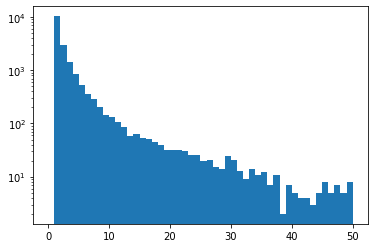

In [238]:
plt.hist(numreviews,bins=50,range=(0,50), log=True)

User matrix: N users, k attributes. Lets' pick k = 10 to start

# Instead, we will use matrix factorization in order to get out resturant attributes and user attributes. We will then save the resturant matrix factorization to a file to use later

In [31]:
userid_rating_matrix = pd.pivot_table(Toronto, 
                                      values='stars_y', 
                                      index=['user_id'], 
                                      columns=['business_id'],
                                      fill_value = 0)

In [32]:
S = np.array(userid_rating_matrix)

In [33]:
from scipy import sparse
sA = sparse.csr_matrix(S)

In [37]:
reviews = sA.nonzero()

In [79]:
reviewindex = []
for i in range(len(reviews[0][0])):
    reviewindex += [tuple(np.array(reviews).T[i][0])]

In [19]:
def calculate_error(U,R,S,ratings):
    error = 0
    predictions=np.dot(U,np.transpose(R))
    for rating in ratings:
        (i,j) = rating
        error += (S[i,j] - predictions[i,j])**2
    return error

def matrix_factorization(U,R,S,ratings,testratings,epochs=100000,learn_rate = .001, lambda_u = 0, lambda_r = 0, num_man_feat = 0):
    inerrors, outerrors = [], []
    for k in range(epochs):
        (i,j) = ratings[np.random.randint(0,len(ratings)-1)] #randomly select a review to preform around
        U[i], R[j][:-num_man_feat] = U[i] + learn_rate*((S[i,j] - np.dot(U[i],R[j]))*R[j] - lambda_u*U[i]), (R[j] + learn_rate*((S[i,j] - np.dot(U[i],R[j]))*U[i]- lambda_r*R[j]))[:-num_man_feat]
        if k%100000 == 0:
            inerrors.append(calculate_error(U,R,S,ratings))
            outerrors.append(calculate_error(U,R,S,testratings))
    return U, R, inerrors, outerrors
    

In [81]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_test, y_train, y_test = train_test_split(reviewindex, reviewindex, test_size=0.2)

# Let's see if we can get out any additional features that may be important! Some things that come to mind are average stars, std(rating), price point, ect

In [16]:
avgrating = []
stdrating = []
numratings = []
for business in userid_rating_matrix.columns:
    stars = Toronto[Toronto['business_id'] == business]['stars_y'].values
    
    avgrating.append(np.mean(stars))
    stdrating.append(np.std(stars))
    numratings.append(len(stars))
    

In [82]:
S = ratings

UserMatrix = np.random.uniform(0,1,size=(80014,30))
ResturantMatrix = np.random.uniform(0,1,size=(7152,30))
#ResturantMatrix = np.append(ResturantMatrix,np.atleast_2d(avgrating).T,1)
#ResturantMatrix = np.append(ResturantMatrix,np.atleast_2d(stdrating).T,1) #learning rate was .06
UserMatrix, ResturantMatrix, inerrors, outerrors = matrix_factorization(UserMatrix,ResturantMatrix,S,reviewindex,ratings_test,epochs=1_000_000_000,learn_rate=.1, lambda_u=.05, lambda_r=.05,num_man_feat = 0)




ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-82-09b7c6a2d10d>", line 7, in <module>
    UserMatrix, ResturantMatrix, inerrors, outerrors = matrix_factorization(UserMatrix,ResturantMatrix,S,reviewindex,ratings_test,epochs=1_000_000_000,learn_rate=.1, lambda_u=.05, lambda_r=.05,num_man_feat = 0)
  File "<ipython-input-19-97b8c0d11032>", line 16, in matrix_factorization
    outerrors.append(calculate_error(U,R,S,testratings))
  File "<ipython-input-19-97b8c0d11032>", line 3, in calculate_error
    predictions=np.dot(U,np.transpose(R))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
Keyboard

KeyboardInterrupt: 

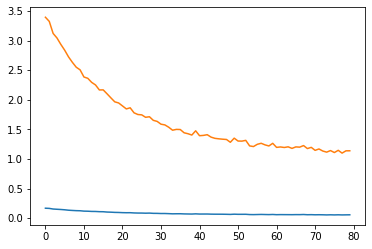

In [533]:
plt.plot(np.array(outerrors[20:])/len(ratings_train))
plt.plot(np.array(inerrors[20:])/len(ratings_test))

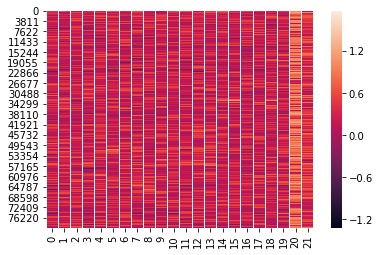

In [480]:
import seaborn as sns
sns.heatmap(UserMatrix)

In [481]:
np.savetxt('Toronto_matrix.txt',ResturantMatrix)

In [534]:
np.savetxt('Toronto_matrix_new.txt',ResturantMatrix)

In [537]:
businesskey = []
for business in userid_rating_matrix.columns:
    businesskey.append(business)

In [542]:
businesskey

['-0CCHBui57tZ_1y_14X-5Q',
 '-0DwB6Swi349EKfbBAOF7A',
 '-0RRiWDtfnS16AKCtfvBZg',
 '-2EAyppKR_2xuLyvJZEbRQ',
 '-2TBP3ZGu7M-FmfoNJvbrQ',
 '-2uYjztVuVZpkTNAC38zdg',
 '-3VEk6j5XnEnOOthoY2jYQ',
 '-3iE3lPp18Tn2ixqIRJB_w',
 '-3pJJf-vHQfysafL0r8YsA',
 '-4eA7Um2eiOKsGLmcXNx_w',
 '-4uT6QFVaRtc2Zmxvtd9Vg',
 '-6GJMc_Ln7csmvWWvY2iug',
 '-6mzdR0YjOToJ8E04Y9O0Q',
 '-6sE5v4OrVGmWxdIrbs-RQ',
 '-76didnxGiiMO80BjSpYsQ',
 '-7BCZH437U5FjmNJ26llkg',
 '-888fFkw3R5YxjPJFdYeGg',
 '-9NsB0DPOp1fG5FvE3iAcg',
 '-9u2uFwhlj3Yq4mG5IweoA',
 '-AVRReI-nfsa0lKlehEojw',
 '-As1YcTVebShW012Q2XGDw',
 '-BAUrljU90RNV-hkokLhXA',
 '-BJ0Z28LoETB_ZsdA4Ikeg',
 '-BVqCPibTNPCNeT0uJsiRg',
 '-Btu8zliXgeSH4eBm1u9Rw',
 '-BvRroH7Q2CbJnp-IygX3Q',
 '-ClafaRWkSRTfieIzO4r3Q',
 '-Cwc_lnYxb9LR4qEbfWE2w',
 '-EX_qttyhm5YNb8NWtAcCQ',
 '-Ej5bLw_bYuKt20kBFQi3w',
 '-FHjXYCSizyNgUv-EXn6Yg',
 '-H5Qoimm5siEJ4RSU4FyHQ',
 '-HBJlnZhUEmIwpnyTFgSRA',
 '-HlfeTND7PATNVduJ_35lA',
 '-HwprJh-Bve1pcDH8_UFeQ',
 '-I3yF7ZzQmYY8iqdTNHHsg',
 '-IOuy7CKwWN54IEzESVOBQ',
 

In [543]:
np.savetxt('Toronto_business_key.txt',businesskey,delimiter=" ", fmt="%s")

In [94]:
f = open("Toronto_business_key.txt", "r")
businesskey = f.read()
businesskey = businesskey.split('\n')[:-1]
ResturantMatrix = np.loadtxt('Toronto_matrix_new.txt')
ResturantDataframe = pd.DataFrame(ResturantMatrix,index=businesskey)

In [95]:
ResturantMatrix = np.loadtxt('Toronto_matrix_new.txt')

In [96]:
ResturantDataframe = pd.DataFrame(ResturantMatrix,index=businesskey)

In [7]:
ResturantDataframe.loc['83mWL4pBlko4x3dWA9V48Q'].values

array([0.42736185, 0.46657482, 0.44803188, 0.12834149, 0.44149913,
       0.24739959, 0.14879847, 0.33392016, 0.07337728, 0.33817452,
       0.08269443, 0.22369433, 0.15289405, 0.09049017, 0.12503043,
       0.24173309, 0.22500266, 0.15810435, 0.25330562, 0.24382438,
       3.66666667, 0.47140452])

In [23]:
def userfactorization(R,U,User_reviews,learn_rate=0.06,lambda_u=.01):
    for i in range(1000):
        review = np.random.choice(list(newuserreviews.keys()))
        Resturant = R.loc[review].values
        U = U + learn_rate*((User_reviews[review] - np.dot(U,Resturant))*Resturant - lambda_u*U)
    return U

In [25]:
newuserreviews = {'83mWL4pBlko4x3dWA9V48Q': 4, '6AGysTrM72Dr1p2_NkL6xQ': 2, '3LkVbMWyiz3igac0I5DeyQ': 3, '6KL0lRKtgTof-NoFuiXwdA': 5}

In [27]:
newuser = np.array([0]*20 + [1] + [0])
newuser = userfactorization(ResturantDataframe,newuser,newuserreviews,learn_rate=.06,lambda_u=.01)

In [32]:
newuser.dot(ResturantDataframe.loc['6KL0lRKtgTof-NoFuiXwdA'].values)

4.893504163799477

In [654]:
np.dot(newuser,ResturantDataframe.loc['83mWL4pBlko4x3dWA9V48Q'])

array([3.76715358])

In [65]:
import functools

def starprob(Star_d, Star_c, std):
    def probdensity(x):
        return 1/(np.sqrt(2*np.pi)*std) * np.exp(-.5*((Star_d - Star_c)/std)**2)
    return sum([probdensity(x)*.1 for x in np.linspace(Star_d-.5,Star_d+.5,11)])

def step(user,resturants,reviews,eps):
    newuser = user + np.random.uniform(-eps,eps)
    oldreviews = user.dot(resturants)
    newreviews = newuser.dot(resturants)
    oldprob = functools.reduce(lambda x,y : x*y,map(functools.partial(starprob,std=.5),reviews,oldreviews))
    newprob = functools.reduce(lambda x,y : x*y,map(functools.partial(starprob,std=.5),reviews,newreviews))
    if np.random.uniform(0,1) < newprob/oldprob:
        return list(newuser)
    else:
        return list(user)

def generate_distribution(user,user_reviews,ResturantDataframe,eps = .1, numsamples=10000):
    resturantmatrix = []
    reviews = []
    for key,val in newuserreviews.items():
        resturantmatrix += [ResturantDataframe.loc[key].values]
        reviews += [val]
    resturantmatrix = np.array(resturantmatrix).T
    reviews = np.array(reviews)
    
    uservals = [list(user)]
    for _ in range(numsamples):
        uservals.append(step(np.array(uservals[-1]),resturantmatrix,reviews,eps))
    return resturantmatrix,uservals
        


In [66]:
resturantmatrix,distribution = generate_distribution(newuser,newuserreviews,ResturantDataframe)

In [75]:
reviewdistribution = [list(np.array(distribution[i]).dot(resturantmatrix)) for i in range(10000)]

(array([  53.,  275.,  991., 2018., 2827., 2276., 1162.,  316.,   73.,
           9.]),
 array([4.26378299, 4.41107767, 4.55837235, 4.70566703, 4.85296171,
        5.00025639, 5.14755106, 5.29484574, 5.44214042, 5.5894351 ,
        5.73672978]),
 <a list of 10 Patch objects>)

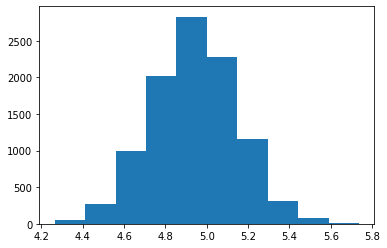

In [84]:
plt.hist(np.array(reviewdistribution).T[3])

In [64]:
distribution[130].dot()

[0.8961672433654377,
 0.30309816198012796,
 1.003904779092506,
 0.12426543085849232,
 -0.42149291531238187,
 0.02002985490228057,
 -1.2598080429205338,
 0.6155040407211303,
 -1.046573219276354,
 -0.353091638396109,
 -0.12676867071928127,
 1.0370921442413814,
 -0.31794813490965323,
 -0.3656658109104004,
 -0.057668957365965653,
 0.05981747453066619,
 0.8348284769873175,
 -1.078864165619112,
 0.3836488120506837,
 0.38879527639249956,
 0.6623310567062228,
 0.7802477094876359]

In [58]:
newuser

array([ 0.9016531 ,  0.30858402,  1.00939064,  0.12975129, -0.41600706,
        0.02551571, -1.25432218,  0.6209899 , -1.04108736, -0.34760578,
       -0.12128281,  1.042578  , -0.31246228, -0.36017995, -0.0521831 ,
        0.06530333,  0.84031434, -1.07337831,  0.38913467,  0.39428114,
        0.66781692,  0.78573357])

In [187]:
class User(object):
    def __init__(self,name,dataframe):
        self.name = name
        self.features = [0]*20 + [1] + [0]
        self.reviews = dict()
        self.numiterations = 5
        self.dataframe = dataframe
        
    def addreview(self,restid,stars):
        self.reviews[restid] = stars
        self._userfactorization()
        self.numiterations += 5
        
        
    def _userfactorization(self,learn_rate=0.05,lambda_u=.05): # default lambda_u = .01
        restmatrix = []
        reviewmatrix = []
        for restid in self.reviews:
            restmatrix += [list(self.dataframe.loc[restid].values)]
            reviewmatrix += [self.reviews[restid]]
        print(reviewmatrix)
            
        for i in range(self.numiterations):
            n = np.random.choice(len(reviewmatrix))
            review, Resturant = reviewmatrix[n], restmatrix[n]
            Resturant = np.array(Resturant)
            features = np.array(self.features)
            self.features = list(features + learn_rate*((review - np.dot(features,Resturant))*Resturant - lambda_u*features))
            
            
    def expectedreview(self,restid):
        resturant = np.array(self.dataframe.loc[restid].values)
        return resturant.dot(self.features)
        

In [188]:
testuser = User('John',ResturantDataframe)

In [190]:
testuser.addreview('-0DwB6Swi349EKfbBAOF7A',5)
print(testuser.expectedreview('-0DwB6Swi349EKfbBAOF7A'))
testuser.addreview('-0DwB6Swi349EKfbBAOF7A',5)
print(testuser.expectedreview('-0DwB6Swi349EKfbBAOF7A'))
testuser.addreview('-0DwB6Swi349EKfbBAOF7A',2)
print(testuser.expectedreview('-0DwB6Swi349EKfbBAOF7A'))
#testuser.addreview('-2TBP3ZGu7M-FmfoNJvbrQ',4)

[5]
4.983777836504226
[5]
4.9837778365048795
[2]
1.9935111346019516


In [180]:
testuser.restmatrix

[[-0.16804039487900882,
  0.14996688324293753,
  0.4139344631218619,
  0.03683472193648203,
  -0.10888717193253235,
  0.21969397080997669,
  0.28698014557127355,
  0.13617078499784632,
  0.17708528061334164,
  0.13641743293421965,
  0.11647866361432173,
  0.008767841026315202,
  -0.20364830992173497,
  0.164296167319362,
  0.15459717993903935,
  0.22075950756367954,
  0.222065755274741,
  0.34326634884680957,
  -0.3756552590281762,
  0.31615561214407717,
  3.6363636363636362,
  1.067940011315521],
 [-0.16804039487900882,
  0.14996688324293753,
  0.4139344631218619,
  0.03683472193648203,
  -0.10888717193253235,
  0.21969397080997669,
  0.28698014557127355,
  0.13617078499784632,
  0.17708528061334164,
  0.13641743293421965,
  0.11647866361432173,
  0.008767841026315202,
  -0.20364830992173497,
  0.164296167319362,
  0.15459717993903935,
  0.22075950756367954,
  0.222065755274741,
  0.34326634884680957,
  -0.3756552590281762,
  0.31615561214407717,
  3.6363636363636362,
  1.067940011315

In [115]:
users = list(userid_rating_matrix.index)

In [243]:
Toronto[Toronto['user_id'] == users[231]]['business_id'].values

array(['EhGPj8iJDIdaHnWg9d5BgA', 'xwmwTpzw9XSwK-UT5Ka3HQ',
       'dd3GZs6zW2t7BM0cbxAzvg', '0kB69ewW3BVse8EhU4kxrQ',
       'fQwB9Z98YEhkJit7c3z51A', 'TLMysu1mWiLEslCBon5W1g',
       'KS_d3F_eIA6iTo6Wtj2O_w', 'JmZj7wzAJ7_4ksjG9WXdqw',
       'q5xrVJ4kivx_yEfJeOKNYQ', '269jIQkeE98UJQUeCgQNuQ',
       'LkfdCPTWU4BNWWpou60Lww', 'QrTvQw_aZOLk_8FZ8tQ_-w',
       'OllK5_S-7svgSwbUfx1xYA', 'uQ7LZpcYRTcibzK1w9E5uQ',
       'W2NzlS8OJzGfDfr9oRz11Q', 'gAt8Vbrf4FiLqLIhkA4bZg',
       'uAAWlLdsoUf872F1FKiX1A', 'VRwT0pscR5vESCrAnUpNwQ',
       'MdjIl105vqCYUGKFSUVytA', 'oKZPgeCOxnVSxudYcn1OtQ',
       '478TIlfHXfT3wvww54QsPg', 'BxCzy1WOVxOrr_G7V4BIvg',
       'QNAookOK29CloYbO11xWWg', 'uANuB3YVqjRWychfyhXJvA',
       'GTNhbajbPNao5ITndlYy6Q', 'vx2T3IspTj6Opxjn95xWRA',
       'fTYFGytoYm6UavQVv5GGBA', 'UxWH8zRYIBgs6Q2oykvRdw',
       'xbmxzInleHymSlaERwhMng', 'CUGswyxGdkcd4IE1oHc80A',
       'wSojc-y-d7MWiGWdy8deCg', 'oc8204pyvf9ixdA4JzzaLA',
       'RwRNR4z3kY-4OsFqigY5sw', 'JluBdtULf0uQADj9xq5YvA

In [138]:
Toronto[Toronto['user_id'] == users[2297]]['stars_y'].values

array([4, 3, 5, 5, 5, 4, 5, 4, 4, 4, 5, 4, 4, 1, 3, 5, 2, 2, 1, 3, 2, 4])

In [244]:
userid = 231
userreviews = {}
userresturants = Toronto[Toronto['user_id'] == users[userid]]['business_id'].values
userrev = Toronto[Toronto['user_id'] == users[userid]]['stars_y'].values
for i in range(42):
    userreviews[userresturants[i]] = userrev[i]

In [245]:
userreviewstuple = []
for key,value in userreviews.items():
    userreviewstuple += [(key,value)]
userreviewstuple

[('EhGPj8iJDIdaHnWg9d5BgA', 4),
 ('xwmwTpzw9XSwK-UT5Ka3HQ', 3),
 ('dd3GZs6zW2t7BM0cbxAzvg', 4),
 ('0kB69ewW3BVse8EhU4kxrQ', 2),
 ('fQwB9Z98YEhkJit7c3z51A', 4),
 ('TLMysu1mWiLEslCBon5W1g', 3),
 ('KS_d3F_eIA6iTo6Wtj2O_w', 2),
 ('JmZj7wzAJ7_4ksjG9WXdqw', 1),
 ('q5xrVJ4kivx_yEfJeOKNYQ', 5),
 ('269jIQkeE98UJQUeCgQNuQ', 3),
 ('LkfdCPTWU4BNWWpou60Lww', 3),
 ('QrTvQw_aZOLk_8FZ8tQ_-w', 2),
 ('OllK5_S-7svgSwbUfx1xYA', 4),
 ('uQ7LZpcYRTcibzK1w9E5uQ', 4),
 ('W2NzlS8OJzGfDfr9oRz11Q', 4),
 ('gAt8Vbrf4FiLqLIhkA4bZg', 3),
 ('uAAWlLdsoUf872F1FKiX1A', 3),
 ('VRwT0pscR5vESCrAnUpNwQ', 3),
 ('MdjIl105vqCYUGKFSUVytA', 3),
 ('oKZPgeCOxnVSxudYcn1OtQ', 2),
 ('478TIlfHXfT3wvww54QsPg', 2),
 ('BxCzy1WOVxOrr_G7V4BIvg', 3),
 ('QNAookOK29CloYbO11xWWg', 4),
 ('uANuB3YVqjRWychfyhXJvA', 2),
 ('GTNhbajbPNao5ITndlYy6Q', 5),
 ('vx2T3IspTj6Opxjn95xWRA', 3),
 ('fTYFGytoYm6UavQVv5GGBA', 1),
 ('UxWH8zRYIBgs6Q2oykvRdw', 2),
 ('xbmxzInleHymSlaERwhMng', 2),
 ('CUGswyxGdkcd4IE1oHc80A', 4),
 ('wSojc-y-d7MWiGWdy8deCg', 3),
 ('oc820

In [251]:
testuser = User('John')
error = []
for i in range(40):
    key,value = userreviewstuple[i][0],userreviewstuple[i][1]
    testuser.addreview(ResturantDataframe,key,value)
    er = 0
    for j in range(i+1,40):
        er += (value - np.array(testuser.features).dot(ResturantDataframe.loc[userreviewstuple[j][0]]))**2
    error += [er/(40-i+1)]
        
    

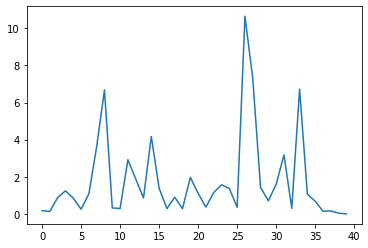

In [252]:
plt.plot(error)

In [233]:
np.array(testuser.features).dot(ResturantDataframe.loc[userresturants[16]])

4.043075986511132

In [234]:
userrev[16]

2

In [274]:
business_data = pd.read_json('yelp_academic_dataset_business.json',lines=True)

In [311]:
business_data[business_data['city'] == 'Toronto']['categories'].values[30].split(',')

['Food',
 ' Poke',
 ' Fast Food',
 ' Sushi Bars',
 ' Restaurants',
 ' Japanese',
 ' Asian Fusion']

In [ ]:
business_data[business_data['city'] == 'Toronto']['attributes'].values[10]['RestaurantsPriceRange2'] # Price range

In [453]:
reload(User_handler)
import User_handler
from User_handler import User

In [454]:
testuser = User()

In [455]:
for i in range(40):
    key,value = userreviewstuple[i][0],userreviewstuple[i][1]
    testuser.addreview(ResturantDataframe,key,value)

In [456]:
testuser.generate_distribution(numsamples=10000)

(0, 5)

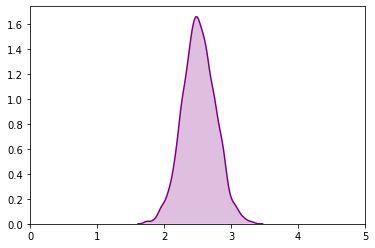

In [480]:
import seaborn as sns
plot = sns.kdeplot(data=testuser.featurematrix.dot(ResturantDataframe.loc[userresturants[26]]),
            shade = True,
            color='purple')
plt.xlim([0,5])

In [467]:
plot = sns.kdeplot(data=testuser.featurematrix.dot(ResturantDataframe.loc[userresturants[42]]),
            shade = True,
            color='purple')
plt.xlim([0,5])

IndexError: index 42 is out of bounds for axis 0 with size 42

In [474]:
var = []
for i in range(40):
    var+= [np.std(testuser.featurematrix.dot(ResturantDataframe.loc[userresturants[i]]))]

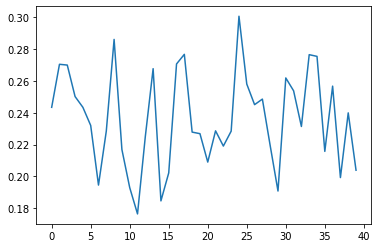

In [475]:
plt.plot(var)

In [451]:
np.array(testuser.features).dot(ResturantDataframe.loc[userresturants[23]])

2.3969302125994343

In [452]:
newuser.ma

('uANuB3YVqjRWychfyhXJvA', 2)

In [476]:
tac = pd.read_csv('tacos.csv')

In [478]:
tac.head()

,name,is_open,latitude,longitude,stars_x,cool,funny,stars_y,al pastor score,al pastor ratio,daal score,daal ratio,lamb shwarma score,lamb shwarma ratio,lamb shawarma score,lamb shawarma ratio,shawarma score,shawarma ratio,taco score,taco ratio,taco score,taco ratio,Weighted taco score
0,Grand Electric,1.0,43.641674,-79.431608,3.5,0.422316,0.432203,3.694915,4.228924,0.016949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.303916,0.858757,13.479040,0.858757,20.438839
1,Wilbur Mexicana,1.0,43.644877,-79.398798,4.0,0.385996,0.220826,4.098743,4.093747,0.023339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.578292,0.651706,12.550149,0.651706,17.423594
2,Playa Cabana,1.0,43.675958,-79.401184,4.0,0.383028,0.252294,3.961009,3.880616,0.034404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.567227,0.582569,11.601654,0.582569,15.478629
3,El Nahual Tacos,1.0,43.666327,-79.406587,4.5,0.886957,0.356522,4.643478,4.995987,0.095652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.071531,0.843478,10.029481,0.843478,15.355165
4,El Caballito,0.0,43.647432,-79.387075,3.5,0.290043,0.259740,3.558442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.506605,0.761905,9.574918,0.761905,13.914608


In [550]:
import FoliumGenerator
reload(FoliumGenerator)
from FoliumGenerator import FoliumMapGenerator

In [551]:
fmap = FoliumMapGenerator(Toronto)

In [554]:
f = fmap.fastsearch_map('tea')

/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://

In [555]:
f.save('test.html')

In [528]:
column = [Toronto[df.index[i]

'Plentea'

In [543]:
Toronto[Toronto['name'] == df.index[0]]['business_id'].values[0]

'8XVAcOZ02IGTQE-pvKhXXw'

In [547]:
tacos = pd.read_csv('tacos.csv')

In [549]:
tacos.set_index('name')

,is_open,latitude,longitude,stars_x,cool,funny,stars_y,al pastor score,al pastor ratio,daal score,daal ratio,lamb shwarma score,lamb shwarma ratio,lamb shawarma score,lamb shawarma ratio,shawarma score,shawarma ratio,taco score,taco ratio,taco score,taco ratio,Weighted taco score
name,,,,,,,,,,,,,,,,,,,,,,
Grand Electric,1.000000,43.641674,-79.431608,3.500000,0.422316,0.432203,3.694915,4.228924,0.016949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.303916,0.858757,13.479040,0.858757,20.438839
Wilbur Mexicana,1.000000,43.644877,-79.398798,4.000000,0.385996,0.220826,4.098743,4.093747,0.023339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.578292,0.651706,12.550149,0.651706,17.423594
Playa Cabana,1.000000,43.675958,-79.401184,4.000000,0.383028,0.252294,3.961009,3.880616,0.034404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.567227,0.582569,11.601654,0.582569,15.478629
El Nahual Tacos,1.000000,43.666327,-79.406587,4.500000,0.886957,0.356522,4.643478,4.995987,0.095652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.071531,0.843478,10.029481,0.843478,15.355165
El Caballito,0.000000,43.647432,-79.387075,3.500000,0.290043,0.259740,3.558442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.506605,0.761905,9.574918,0.761905,13.914608
Banh Mi Boys,1.000000,43.648827,-79.396970,4.500000,0.479185,0.357839,4.265722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.104034,0.226749,12.083884,0.226749,13.557141
Han Ba Tang,1.000000,43.762908,-79.411564,3.500000,0.523810,0.261905,3.659864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.334372,0.506803,9.341757,0.506803,12.026407
Chula Taberna Mexicana,1.000000,43.669256,-79.335902,4.000000,0.210000,0.040000,3.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.070744,0.710000,8.087227,0.710000,11.510339
Itacate,1.000000,43.679391,-79.437161,4.500000,0.514286,0.542857,4.457143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.475731,0.857143,7.366681,0.857143,11.475718


In [556]:
Toronto

[autoreload of certifi failed: Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/anaconda3/lib/python3.7/site-packages/certifi/__init__.py", line 1, in <module>
    from .core import contents, where
ImportError: cannot import name 'contents' from 'certifi.core' (/anaconda3/lib/python3.7/site-packages/c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
-0CCHBui57tZ_1y_14X-5Q,-0.199355,-0.213382,0.057003,-0.084567,0.154380,0.232858,0.056402,0.571680,0.309985,0.082006,0.260406,0.242704,0.053543,-0.100849,0.137679,-0.062611,0.282973,0.093551,0.514379,0.164202,4.437500,0.704339
-0DwB6Swi349EKfbBAOF7A,-0.168040,0.149967,0.413934,0.036835,-0.108887,0.219694,0.286980,0.136171,0.177085,0.136417,0.116479,0.008768,-0.203648,0.164296,0.154597,0.220760,0.222066,0.343266,-0.375655,0.316156,3.636364,1.067940
-0RRiWDtfnS16AKCtfvBZg,0.150753,0.106442,0.527362,0.320549,0.089261,0.285370,0.275887,0.676239,-0.178106,0.444575,0.065988,0.646628,0.067355,-0.125469,-0.141402,0.209949,0.685352,0.497533,0.050069,0.404332,4.500000,0.763763
-2EAyppKR_2xuLyvJZEbRQ,0.533801,-0.008236,-0.019697,0.168720,0.233287,0.617018,0.195861,0.146221,-0.273664,0.388665,0.165283,-0.091326,-0.176000,-0.493235,0.282128,-0.343072,-0.108844,-0.379259,-0.036859,-0.176317,2.142857,1.389954
-2TBP3ZGu7M-FmfoNJvbrQ,0.353537,-0.474968,0.187420,0.467257,-0.456991,-0.116267,0.560547,0.247343,0.667747,0.050840,0.215558,0.029327,0.017836,-0.752711,0.293467,0.609661,0.076008,0.105526,0.231568,-0.113439,3.736842,1.068304


In [562]:
wilbur = Toronto[Toronto.name == 'Wilbur Mexicana']['business_id'].values[0]

In [571]:
def cos_sim(a,b):
    num = a.dot(b)
    dem = np.sqrt(a.dot(a))*np.sqrt(b.dot(b))
    return num/dem

ResturantDataframe.loc[wilbur].values

array([-0.34475617,  0.36966781, -0.23887918,  0.50042529,  0.08796209,
        0.1050168 , -0.11049015,  0.27880415,  0.13595576,  0.73285077,
       -0.25638841,  0.29109654, -0.18847655,  0.16717659, -0.23325473,
        0.34745896,  0.01625709, -0.02700073,  0.30765097,  0.11913035,
        4.09874327,  0.91228315])

In [584]:
cossim = [cos_sim(ResturantDataframe.loc[wilbur].values[:20], ResturantDataframe.iloc[i].values[:20]) for i in range(5000)]
for i in range(5000):
    if cossim[i] > .6:
        print(i)

660
899
956
1003
1417
1652
1666
1935
1959
2141
2151
2168
2203
2424
2566
2572
2937
2961
3312
3637
4086
4838


In [588]:
Toronto[Toronto.business_id == ResturantDataframe.iloc[4838].name]

,Unnamed: 0,address,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,stars_x,state,cool,date,funny,stars_y,text,user_id,simid,usid,taco score,taco ratio
221516,2691439,109 McCaul St,ezFB98nX2V_E0B6HuKHl3A,"Restaurants, Burgers, Fast Food, Food, Coffee ...",Toronto,"{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ...",1,43.653718,-79.390904,McDonald's,M5T 3K5,2.5,ON,0,2014-05-26 15:07:10,0,3,"- helpful staff, sometimes unfriendly/rushed b...",uusBaJX5IaCExRFx2UBP5g,4838,73555,NaN,NaN
221517,2691440,109 McCaul St,ezFB98nX2V_E0B6HuKHl3A,"Restaurants, Burgers, Fast Food, Food, Coffee ...",Toronto,"{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ...",1,43.653718,-79.390904,McDonald's,M5T 3K5,2.5,ON,0,2018-05-29 13:40:42,0,1,"lazy staff, unfriendly...\n\nwhen you order a ...",PVK-navp8_0C42dexmG0ZQ,4838,33134,NaN,NaN
221518,2691441,109 McCaul St,ezFB98nX2V_E0B6HuKHl3A,"Restaurants, Burgers, Fast Food, Food, Coffee ...",Toronto,"{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ...",1,43.653718,-79.390904,McDonald's,M5T 3K5,2.5,ON,1,2012-08-24 01:31:07,1,3,this mcdonald's recently upgraded to a mccafe....,5S8awuCJpaAFvcYlMis2EQ,4838,8176,NaN,NaN
221519,2691442,109 McCaul St,ezFB98nX2V_E0B6HuKHl3A,"Restaurants, Burgers, Fast Food, Food, Coffee ...",Toronto,"{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ...",1,43.653718,-79.390904,McDonald's,M5T 3K5,2.5,ON,0,2014-01-02 20:11:03,1,3,disclaimer: i haven't eaten here. except for a...,eqWEgMH-DCP74i82BEAZzw,4838,53418,NaN,NaN
221520,2691443,109 McCaul St,ezFB98nX2V_E0B6HuKHl3A,"Restaurants, Burgers, Fast Food, Food, Coffee ...",Toronto,"{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ...",1,43.653718,-79.390904,McDonald's,M5T 3K5,2.5,ON,0,2011-10-12 05:00:32,0,3,oh mcds.. i have a love/hate relationship with...,oZyiiNdA-I5zk_EHUmGRMQ,4838,65647,NaN,NaN
221521,2691444,109 McCaul St,ezFB98nX2V_E0B6HuKHl3A,"Restaurants, Burgers, Fast Food, Food, Coffee ...",Toronto,"{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ...",1,43.653718,-79.390904,McDonald's,M5T 3K5,2.5,ON,0,2019-03-17 14:22:23,0,1,slowest mcdonald's i've ever been to. took 20 ...,KbFeKQpN3DMWqbbHQmSbEg,4838,27049,NaN,NaN
221522,2691445,109 McCaul St,ezFB98nX2V_E0B6HuKHl3A,"Restaurants, Burgers, Fast Food, Food, Coffee ...",Toronto,"{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ...",1,43.653718,-79.390904,McDonald's,M5T 3K5,2.5,ON,3,2011-11-24 02:42:03,7,2,this mcdonald's is located in the village by t...,BGzavA_ddMr-jGmhArv7fg,4838,15408,NaN,NaN


# From the resturant matrix factorization, we can also use TSNE to visualize and see if we can cluster similar resturants togeather. The results are a little bit all over the place, but certainly there are clusters of resturants that have some similarities (fast food, for instance)

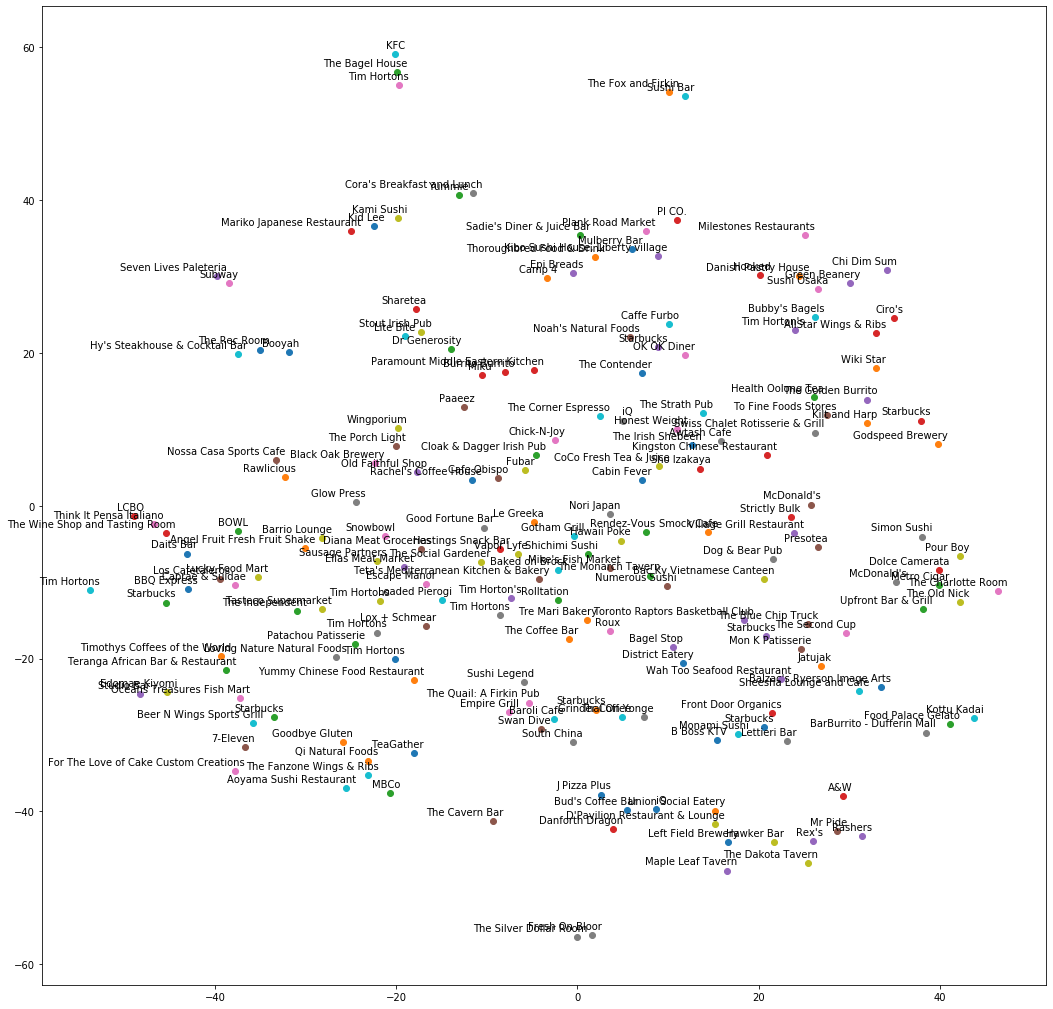

In [620]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

tsne = TSNE(perplexity=5, n_components=2, init="pca", n_iter=5000)
plot_only = 50
coords = tsne.fit_transform(rm.T[0:20].T[0:200])

plt.figure(figsize=(18, 18))
labels = [Toronto[Toronto.business_id == ResturantDataframe.iloc[i].name]['name'].values[0] for i in range(200)]
for i, label in enumerate(labels):
    x, y = coords[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(10, 4),
                 textcoords="offset points",
                 ha="right",
                 va="bottom")

#plt.show()
plt.savefig('TSNE',dpi=500)

In [ ]:
tsne.

In [604]:
ResturantDataframe.iloc[0].name

'-0CCHBui57tZ_1y_14X-5Q'